In [520]:
%%bash
pip install tsfresh

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [698]:

import os
import inspect
import sys
import pandas as pd
import charts
import numpy as np
import pylab as pl
from scipy import spatial
from scipy.spatial import distance
from sklearn.cluster import MeanShift
import time
import math


from opengrid.library import houseprint

In [699]:
hp = houseprint.Houseprint()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
34 Sites created
34 Devices created
97 sensors created
Houseprint parsing complete


In [700]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

In [701]:
gas = hp.find_sensor('212ce724e124fbde0fb649396375d099')
#gas = hp.find_sensor('a6028457292f1866b468b63adcc82ee3') 2
#gas = hp.find_sensor('a6028457292f1866b468b63adcc82ee3')

In [702]:
head = pd.Timestamp('20151110')
tail = pd.Timestamp('20151128')
originalGraph = gas.get_data(head=head, tail=tail, diff=True, resample='min', unit='kW')
originalGraphDf=pd.DataFrame(originalGraph)
originalGraphDfDropNa = originalGraphDf.dropna()
charts.plot(originalGraph, stock=True, show='inline')

Using tmpo database from /data/.tmpo/tmpo.sqlite3


In [703]:
#dfCompare=dfRepeatedValues.ix[pd.Timestamp('2015-11-13 16:25:00+00:00'):pd.Timestamp('2015-11-13 17:16:00+00:00')]
#dfCompare2=dfRepeatedValues.ix[pd.Timestamp('2015-11-14 15:25:00+00:00'):pd.Timestamp('2015-11-14 16:45:00+00:00')]
dfCompareOriginal=originalGraphDf.ix[pd.Timestamp('2015-11-13 16:25:00+00:00'):pd.Timestamp('2015-11-13 17:16:00+00:00')]
dfCompareOriginal2=originalGraphDf.ix[pd.Timestamp('2015-11-14 15:25:00+00:00'):pd.Timestamp('2015-11-14 16:45:00+00:00')]
dfCompareOriginal3=originalGraphDf.ix[pd.Timestamp('2015-11-23 08:20:00+00:00'):pd.Timestamp('2015-11-23 13:45:00+00:00')]
dfCompareOriginal4=originalGraphDf.ix[pd.Timestamp('2015-11-18 04:47:00+00:00'):pd.Timestamp('2015-11-18 05:29:00+00:00')]
dfCompareOriginal5=originalGraphDf.ix[pd.Timestamp('2015-11-17 21:03:00+00:00'):pd.Timestamp('2015-11-17 21:05:00+00:00')]
dfCompareOriginal6=originalGraphDf.ix[pd.Timestamp('2015-11-11 20:20:00+00:00'):pd.Timestamp('2015-11-11 20:37:00+00:00')]
dfCompareOriginal7=originalGraphDf.ix[pd.Timestamp('2015-11-17 18:21:00+00:00'):pd.Timestamp('2015-11-17 18:34:00+00:00')]

In [704]:
charts.plot(dfCompareOriginal, stock=True, show='inline')

<h3> Different compare methods </h3>

In [705]:
def diffArrays(array1,array2):
    array=[]
    if array1.index.size==array2.index.size:
        for i in range(0,array1.index.size):
            array.append(array2.iloc[i]-array1.iloc[i])
    df=pd.DataFrame(array)
    return df

<h4> Manhattan Distance: the method we will use </h4>

In [706]:
def manhattanDistance2(s1,s2):
    dist = distance.cityblock(s1,s2)
#     maxValues=np.maximum(s1,s2)
#     maxValues=np.max(maxValues)
#     manhattan=dist/maxValues
    return dist

In [707]:
def euclideanDistance(s1,s2):
    #Verwacht een numpy array
    dist = np.linalg.norm(s1-s2)
    return dist

In [708]:
def cosineSimilarity(s1,s2):
    similarity = 1 - spatial.distance.cosine(s1, s2)
    return similarity

In [709]:
def mahalanobisDistance(s1,s2):
    similarity = 1 - distance.mahalanobis(s1,s2)
    return similarity

In [710]:
def chebychev(s1,s2):
    dist =  distance.chebyshev(s1,s2)
    return dist

In [711]:
def manhattanDistance(s1,s2):
    difference=diffArrays(s1,s2)
    absDifference=abs(difference)
    sumOfValues=np.sum(absDifference)
    maxValues=np.maximum(s1,s2)
    maxValues=np.max(maxValues)
    manhattan=sumOfValues/maxValues
    return manhattan

In [712]:
def hammingDistance(s1, s2):
    """Return the Hamming distance between equal-length sequences"""
    if len(s1) != len(s2):
        raise ValueError("Undefined for sequences of unequal length")
    return sum(el1 != el2 for el1, el2 in zip(s1, s2))

In [713]:
def paa_transform(timeSeries, n_pieces):
    splitted = np.array_split(timeSeries, n_pieces) ## along columns as we want
    return np.asarray(map(lambda xs: xs.mean(axis = 0), splitted))

In [714]:
def znormalization(ts):
    #Pakt mean, std van kolom.
    meanCalc = ts.mean(axis = 0)
    stdCalc = ts.std(axis = 0)
    return (ts - meanCalc) / stdCalc

In [715]:
def sax_transform(ts, n_pieces, alphabet):
    """
    ts: columns of which are time serieses represented by np.array
    n_pieces: number of segments in paa transformation
    alphabet: the letters to be translated to, e.g. "abcd", "ab"
    return np.array of ts's sax transformation
    Steps:
    1. znormalize
    2. paa
    3. find norm distribution breakpoints by scipy.stats
    4. convert paa transformation into strings
    """
    from scipy.stats import norm
    alphabet_sz = len(alphabet)
    thrholds = norm.ppf(np.linspace(1./alphabet_sz, 
                                    1-1./alphabet_sz, 
                                    alphabet_sz-1))
    def translate(ts_values):
        return np.asarray([(alphabet[0] if ts_value < thrholds[0]
                else (alphabet[-1] if ts_value > thrholds[-1]
                      else alphabet[np.where(thrholds <= ts_value)[0][-1]+1]))
                           for ts_value in ts_values])
    paa_ts = paa_transform(znormalization(ts), n_pieces)
    return np.apply_along_axis(translate, 0, paa_ts)

In [716]:
def makeArray(array1):
    arrayValues=[]    
    for i in range(0, array1.size-1):
        if(i<array1.size):
             arrayValues.append(ord(array1.iloc[i])-97)
    df=pd.DataFrame(arrayValues)
    return df

In [717]:

def makeDiffArray(array): #Excepts a letter array
    arrayValues=[]    
    for i in range(0, array.size-1):
        if(i<array.size):
             arrayValues.append(ord(array.iloc[i+1])-ord(array.iloc[i]))
    df=pd.DataFrame(arrayValues)
    return df          


In [718]:
def differenceNumbers(array): #Expects array of numbers @
    arrayValues=[]
    for i in range(0, array.index.size):
        arrayValues.append(np.diff(array.iloc[i], axis=-1))
    df=pd.DataFrame(arrayValues)
    return df

In [719]:
def diffArrays(array1,array2):
    array=[]
    if array1.index.size==array2.index.size:
        for i in range(0,array1.index.size):
            array.append(array2.iloc[i]-array1.iloc[i])
    df=pd.DataFrame(array)
    return df

In [720]:
zScores=znormalization(originalGraph)

<h3> Visualisation of the different graphs (PAA, SAX, original graph, zscores) </h3>

In [721]:
#10-18
# paaTransform = paa_transform(zScores,1850)
# paaTransfo = np.repeat(paaTransform,6, axis = 0)
# pl.figure()
# pl.plot(zScores, '-+')
# pl.plot(paaTransfo)
# pl.legend(loc = "upper left")

In [722]:
# originalGraphDf=pd.DataFrame(originalGraph)
# paaTransfoDf=pd.DataFrame(paaTransfo)
# paaTransfoDf=paaTransfoDf.iloc[:paaTransfoDf.size-27]
# paaTransfoDf.index=originalGraphDf.index
# graph = pd.concat([paaTransfoDf,zScores],axis=1).dropna()
# charts.plot(graph,stock=True,show='inline')


<h3> Change numbers to letters </h3>

In [723]:
# saxTransformation=sax_transform(originalGraph, 1850, "abcdefghijklmn")

In [724]:
# '''
# Werkwijze:
# Dataframes gebruiken!
# -sax transfo
# -lettersq->nummers (makeArray())
# -np.repeat (plateau's)
# -plot(paa_transform+repeater,^)
# '''

# letters=pd.DataFrame(saxTransformation)
# letters.columns=['col1']
# lettersToNumSax=makeArray(letters.col1) #Expects a pandaframe

# repeatedValues=np.repeat(lettersToNumSax.as_matrix(),6) #expects an array

# dfRepeatedValues=pd.DataFrame(repeatedValues)

# dfRepeatedValues=dfRepeatedValues.iloc[:dfRepeatedValues.size-21]
# paaTransfoDf.index=dfRepeatedValues.index

# concatinatePaaAndSax=pd.concat([znormalization(dfRepeatedValues),paaTransfoDf],axis=1)
# concatinatePaaAndSax.columns=['col1','col2']

# charts.plot(concatinatePaaAndSax,stock=True,show='inline')


In [725]:
# dfRepeatedValues.index=zScores.index
# saxVsOriginalGraph=pd.concat([(dfRepeatedValues), znormalization(originalGraph)],axis=1).dropna()
# charts.plot(saxVsOriginalGraph, stock=True, show='inline')

In [726]:
# saxVsOriginalGraph2=pd.concat([(dfRepeatedValues), (originalGraph)],axis=1).dropna()
# charts.plot(saxVsOriginalGraph2, stock=True, show='inline')

# Storing comparing arrays used in the methods below

In [727]:
# dfCompare=dfRepeatedValues.ix[pd.Timestamp('2015-11-13 16:25:00+00:00'):pd.Timestamp('2015-11-13 17:16:00+00:00')]
# dfCompare2=dfRepeatedValues.ix[pd.Timestamp('2015-11-14 15:25:00+00:00'):pd.Timestamp('2015-11-14 16:45:00+00:00')]
dfCompareOriginal=originalGraphDf.ix[pd.Timestamp('2015-11-13 16:25:00+00:00'):pd.Timestamp('2015-11-13 17:16:00+00:00')]
dfCompareOriginal2=originalGraphDf.ix[pd.Timestamp('2015-11-14 15:25:00+00:00'):pd.Timestamp('2015-11-14 16:45:00+00:00')]

# New method with timestamp correction and automatic graph creation

In [739]:
 def calculate_lowest_values(dfWithValues, arrayToCompare, amountOfSaves, amountOfValues):
    start=time.time()
    #Create list where values on which the different methods will act will be saved temporarily
    #This list will be cleared every time
    valuesList=[]

    #Create list with results of the methods
    resultList=[]
    dfResult=pd.DataFrame(resultList)
    compareToArray=np.array(arrayToCompare)
    i=0 #Loops through list arrayToCompare.size times
    j=0 #Amount of values considered, and calculated.
    loopIndex=0 #Loops through the resultslist, as long as its size
    currentSaves=0 #Current amount of variables saved
    arrayWithValues=np.array(dfWithValues)
    startingTimeStamp=dfWithValues.index[0]#Todo with speed
    stopTimeStamp=dfWithValues.index[arrayToCompare.size-1]
    
    
    #LOOPING THROUGH LIST
    while i < arrayToCompare.size+j: #i is dependent on j, i updates as j updates.
        valuesList.append(([arrayWithValues[i][0]]))
        i=i+1
        if(i==(arrayToCompare.size+j)) and(j<amountOfValues) and (i<=(dfWithValues.size-arrayToCompare.size)): #amountOfValuesToBeConsidered.
            #j = the minute at this moment. i = starting from the current minute, adding the size of the array to compare.
            #Stops running when the limit of values to be considered is reached, being the size the original array.
            valuesToArray=np.array(valuesList)
            if(j==0) or (manhattanDistance2(compareToArray,valuesToArray)!=resultList[len(resultList)-1][0]):
                #Create list with values. Save them in "resultList". Euclidean score, startTimestamp, stopTimestamp
                resultList.append([manhattanDistance2(compareToArray,valuesToArray), startingTimeStamp,stopTimeStamp]) 
            j=j+1
            startingTimeStamp=dfWithValues.index[j] #startingTimeStamp: current minute considered
            stopTimeStamp=dfWithValues.index[i] #stopTimeStamp: current minute considered + size of array to compare.
            i=j
            valuesList=[]
    
    
    #SAVING ONLY RELEVANT VALUES       
    #print "All",amountOfValues,"are stored in an array.\nNow looping through the list to find the lowest values.\nThis is done by checking if the value before and after a certain value is higher than that value."
    while loopIndex < len(resultList):
        if(currentSaves<amountOfSaves): #First save x amount of variables into the array
            [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex][0], resultList[loopIndex][1], resultList[loopIndex][2]]
            dfResult=dfResult.append(pd.DataFrame([[value, startTimeStamp,stopTimeStamp]], index=[currentSaves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
            currentSaves=currentSaves+1
            #print "index:",loopIndex
        #Only adding values if value is lower than the 2 neighbours
        elif(resultList[loopIndex-1][0] < resultList[loopIndex-2][0]) and (resultList[loopIndex-1][0] < resultList[loopIndex][0]) and resultList[loopIndex-1][0] < dfResult.max()['Manhattan']:
            #print "Value", resultList[loopIndex-1][0],",Index:",loopIndex-1,"has a lower value than value left and right to it.(",resultList[loopIndex-2][0],",",resultList[loopIndex][0],") nIt will now replace", dfResult['Euclidean'].max(),"in the dataset."
            [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex-1][0], resultList[loopIndex-1][1], resultList[loopIndex-1][2]]
            thresholdValue=arrayToCompare.size/10
            listWithValues=[]
            maxValue=0
            i=0 
            
            
            #!!!Timestamps are important. If timestamp is within the range of another timestamp already present,
            #they will overwrite eachother instead of adding a new unique value
            while i < dfResult.index.size:
                if(startTimeStamp >= dfResult['startTimeStamp'][i]) and (startTimeStamp <= dfResult['stopTimeStamp'][i]-pd.Timedelta(minutes=thresholdValue)):
                    if(dfResult.loc[i][0] > maxValue) and (dfResult.loc[i][0]!=0): #Store the maximum value, of the range between start and stoptimestamp.
                        maxValue=dfResult.loc[i][0]
                        ts=dfResult.loc[i][1]
                    elif(dfResult.loc[i][0]==0):
                         #print "THE PERFECT MATCH IS FOUND WITH TIMESTAMP:", ts," AND VALUE: ", dfResult.loc[i][0]
                        maxValue=1
                i=i+1
            if(maxValue==0): #Means that start and stop timestamp are outside of the boundaries
                dfResult.loc[dfResult['Manhattan'].idxmax()]=[value,startTimeStamp, stopTimeStamp]
            elif(value < maxValue): #Check if the current value is smaller than the Maximum value encountered
                    dfResult.loc[dfResult['Manhattan']== maxValue] = [value, startTimeStamp, stopTimeStamp]
        loopIndex=loopIndex+1
    dfResult=dfResult.sort_values(['startTimeStamp'])
    print "until graph:", (time.time()-start)
    
    
    ###CREATING GRAPH###
    listWithGraphs=[]
    listWithGraphs=pd.DataFrame(listWithGraphs)
    for i in range (0, dfResult.index.size):
        listWithGraphs=listWithGraphs.append(originalGraphDfDropNa.ix[pd.Timestamp(dfResult['startTimeStamp'][i]):pd.Timestamp(dfResult['stopTimeStamp'][i])])
    
    print "after graph", (time.time()-start)
    return dfResult
#     return charts.plot(listWithGraphs, stock=True, show='inline')
        

# Method on original values and PAA values

### Without TS correction

In [730]:
#calculateWeightsNew

### With TS correction and Graph

#### Original

In [731]:
#calculateWeightsNewGraph()

<h2> Calculating threshold value </h2>

In [732]:
def convert(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [734]:
# bestValuesDf=calculateWeightsNew(originalGraphDfDropNa, dfCompareOriginal, 100, originalGraphDfDropNa.size)
# thresholdValue = bestValuesDf['Manhattan'].mean()*1.5


In [749]:
best_values_df=calculate_lowest_values(originalGraphDfDropNa, dfCompareOriginal, 100, originalGraphDfDropNa.size)

until graph: 74.696046114
after graph 74.9901759624


In [751]:
best_values_df

,Manhattan,startTimeStamp,stopTimeStamp
89,152.823014,2015-11-10 16:58:00+00:00,2015-11-10 17:49:00+00:00
90,219.478353,2015-11-10 18:46:00+00:00,2015-11-10 19:37:00+00:00
88,193.686958,2015-11-11 06:40:00+00:00,2015-11-11 07:31:00+00:00
87,165.342736,2015-11-11 18:17:00+00:00,2015-11-11 19:08:00+00:00
5,199.368801,2015-11-12 05:22:00+00:00,2015-11-12 06:13:00+00:00
41,64.541744,2015-11-12 09:57:00+00:00,2015-11-12 10:48:00+00:00
7,108.904708,2015-11-12 19:14:00+00:00,2015-11-12 20:05:00+00:00
86,213.320130,2015-11-13 05:27:00+00:00,2015-11-13 06:18:00+00:00
43,0.000000,2015-11-13 16:25:00+00:00,2015-11-13 17:16:00+00:00
16,195.060656,2015-11-13 17:35:00+00:00,2015-11-13 18:26:00+00:00


In [753]:
df100 = [1]
df100=pd.DataFrame(df100,index=[0])
for i in range (1,100):
    df100=df100.append(pd.DataFrame([i], index=[i]))
best_values_df.index=df100.index

<h2> Clustering </h2>

<h3> Storing mean/max/median </h3>

In [837]:
maxValues=[]
dfMaxValues=pd.DataFrame(maxValues)
meanValues=[]
medianValues=[]
for i in range (0,100):
        maxValues.append(originalGraphDfDropNa.ix[pd.Timestamp(best_values_df['startTimeStamp'].iloc[i]):pd.Timestamp(best_values_df['stopTimeStamp'].iloc[i])].max())
        meanValues.append(originalGraphDfDropNa.ix[pd.Timestamp(best_values_df['startTimeStamp'].iloc[i]):pd.Timestamp(best_values_df['stopTimeStamp'].iloc[i])].mean())
        medianValues.append(originalGraphDfDropNa.ix[pd.Timestamp(best_values_df['startTimeStamp'].iloc[i]):pd.Timestamp(best_values_df['stopTimeStamp'].iloc[i])].median())

<h3> Normalizing the results and storing in df </h3>

In [838]:
max_values=pd.DataFrame(maxValues)
mean_values=pd.DataFrame(meanValues)
median_values=pd.DataFrame(medianValues)
norm_max_values= max_values/max_values.max()
norm_mean_values=mean_values/mean_values.max()
norm_median_values=median_values/median_values.max()
norm_manhattan=best_values_df['Manhattan']/best_values_df['Manhattan'].max()

In [855]:
best_values_df_concat = pd.concat([bestValuesDf,max_values, mean_values, median_values,norm_manhattan*1.5,norm_max_values,norm_mean_values,norm_median_values],axis=1)
best_values_df_concat.columns=['Manhattan','startTimeStamp','stopTimeStamp','Max', 'Mean', 'Median', 'normManhattan','normMax', 'normMean','normMedian']

<h3> Clustering operation </h3>

In [856]:
df_result = pd.DataFrame(data=[best_values_df_concat['normManhattan'].as_matrix(),best_values_df_concat['normMedian'].as_matrix()]).transpose()
result=df_result.as_matrix()

In [857]:
ms = MeanShift()
ms.fit(result)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
n_cluster = len(np.unique(labels))
colors = 10*['g.', 'r.', 'c.', 'b.', 'k.', 'y.', 'm.']

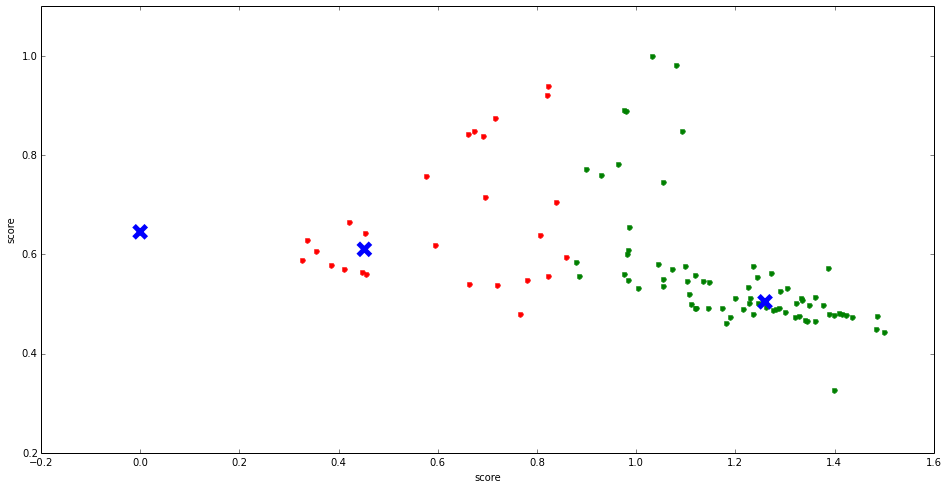

In [858]:
for i in range(len(result)):
    plt.plot(result[i][0], result[i][1], colors[labels[i]], markersize = 10)

plt.scatter(cluster_centers[:,0],cluster_centers[:,1], marker = "x", s = 150, linewidths = 5, zorder = 10)
plt.xlabel('score')
plt.ylabel('score')
plt.show()

<h3>Printing graph according to type </h3>

In [861]:
best_values_df_concat.insert(loc=10, column='Type', value=labels)

[0 0 0 0 0 1 1 0 2 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0]


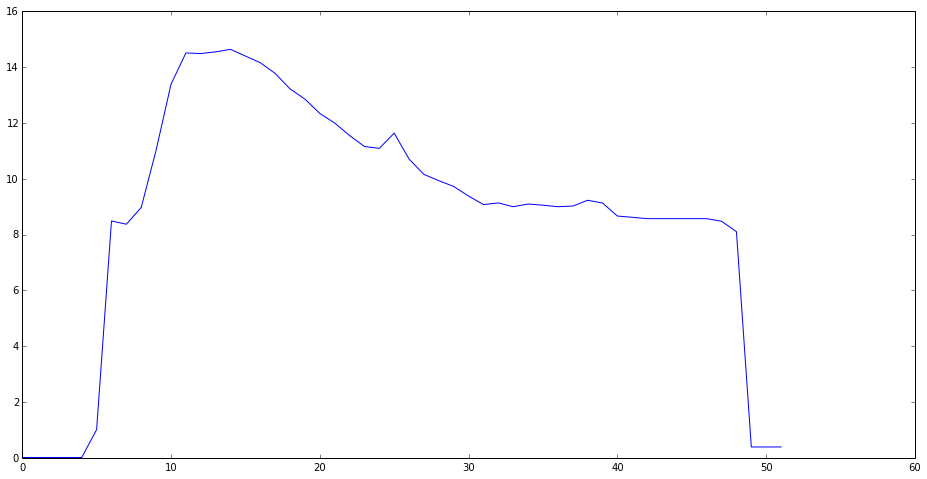

In [864]:
print labels
for i in range (0,100):
    if best_values_df_concat['Type'].iloc[i] == 2:
        plt.plot(originalGraphDfDropNa.ix[pd.Timestamp(best_values_df_concat['startTimeStamp'].iloc[i]):pd.Timestamp(best_values_df_concat['stopTimeStamp'].iloc[i])])     

In [834]:
best_values_df_concat.insert(loc=10, column='Type', value=labels)

In [830]:
# labels=pd.DataFrame(labels)
# concat= pd.concat([best_values_df_concat,labels],axis=1)
# concat.columns=['Manhattan','startTimeStamp','stopTimeStamp','Max', 'Mean', 'Median', 'normManhattan','normMax', 'normMean','normMedian', 'Type']

<h3>Adding height/mean/median to dataframe</h3>

<h4> Clusters and labels for height </h4>

In [694]:
df_result_height = pd.DataFrame(data=[best_values_df_concat['normManhattan'].as_matrix(),best_values_df_concat['normMedian'].as_matrix(),best_values_df_concat['normMean'].as_matrix()]).transpose()
result_height=df_result_height.as_matrix()

In [695]:
ms = MeanShift()
ms.fit(result_height)
labels_height = ms.labels_
cluster_centers_height = ms.cluster_centers_
n_cluster_height = len(np.unique(labels_height))
colors = 10*['g.', 'r.', 'c.', 'b.', 'k.', 'y.', 'm.']

In [696]:
# labels_height=pd.DataFrame(labels_height)
# df=(labels-labels_height)
# # with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
# #     print df

[0 0 0 0 0 1 2 0 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 0 1 2 2 0 0 2 2 2
 0 0 0 2 0 2 0 0 1 0 0 0 0 0 0 2 2 2 0 0 0 1 0 0 0 0 0 0 2 0 0 2 0 1 0 2 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 0 2 0 0 0 2 2 1 1 0 0]


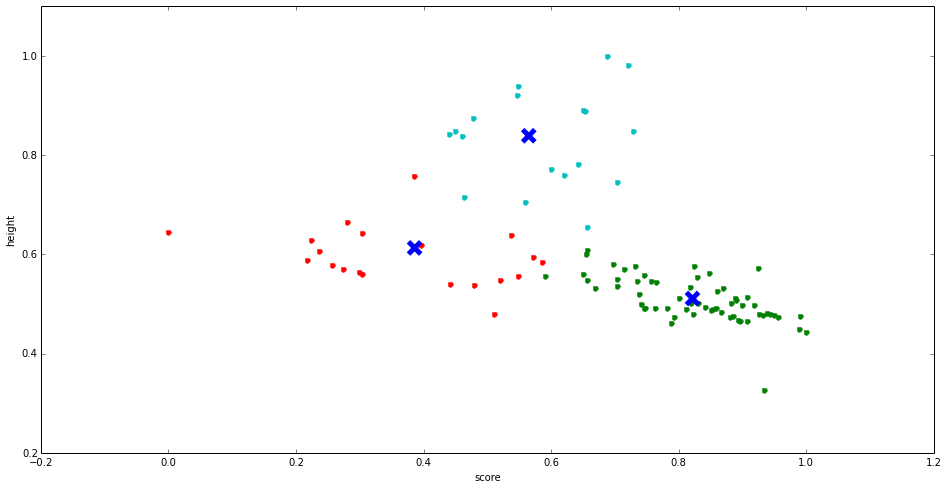

In [697]:
for i in range(len(result_height)):
    plt.plot(result_height[i][0], result_height[i][1], colors[labels_height[i]], markersize = 10)

plt.scatter(cluster_centers_height[:,0],cluster_centers_height[:,1], marker = "x", s = 150, linewidths = 5, zorder = 10)
print labels_height
plt.xlabel('score')
plt.ylabel('height')
plt.show()

In [689]:
labels_height=pd.DataFrame(labels_height)
concat_height= pd.concat([bestValuesDfConcat,labels_height],axis=1)
concat_height.columns=['Manhattan','startTimeStamp','stopTimeStamp','Max', 'Mean', 'Median', 'normManhattan','normMax', 'normMean','normMedian', 'Type']

<h3> Printing different cluster labels </h3>

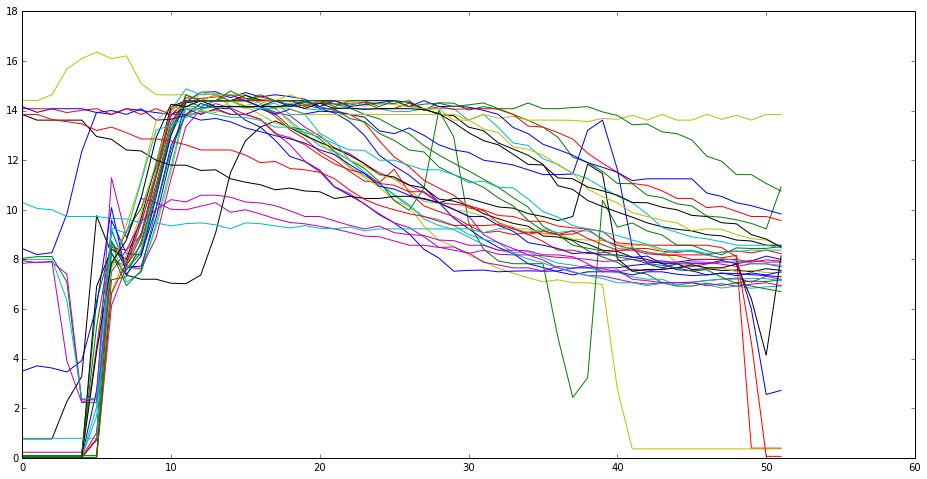

In [693]:
for i in range (0,100):
    if concat_height['Type'].iloc[i] == 1:
        plt.plot(originalGraphDfDropNa.ix[pd.Timestamp(concat_height['startTimeStamp'].iloc[i]):pd.Timestamp(concat_height['stopTimeStamp'].iloc[i])])

<h4> Clusters and labels for median </h4>

In [ ]:
labels_median= pd.DataFrame(labels_median)
concat_median= pd.concat([bestValuesDfConcat,labels_median],axis=1)
concat_median.columns=['Manhattan', 'startTimeStamp','stopTimeStamp','Max', 'Median', 'Mean','Type']

<h3>Graphs clustering for height</h3>

In [ ]:
for i in range (0,100):
    if concatNew['Type'].iloc[i] == 2:
        plt.plot(originalGraphDropNa.ix[pd.Timestamp(concatNew['startTimeStamp'].iloc[i]):pd.Timestamp(concatNew['stopTimeStamp'].iloc[i])])

<h2> Using mean / median value as parameter for clustering </h2>

In [ ]:
meanValues=[]
for i in range (0,100):
        meanValues.append(originalGraphDropNa.ix[pd.Timestamp(concat['startTimeStamp'].iloc[i]):pd.Timestamp(concat['stopTimeStamp'].iloc[i])].mean())

<h4>Comparison with dataframe which looks nothing like the original dataframe</h4>

In [ ]:
charts.plot(originalGraph, stock=True, show='inline')

In [ ]:
dfCompareOriginal10=originalGraphDf.ix[pd.Timestamp('2015-11-14 09:00:00+00:00'):pd.Timestamp('2015-11-14 09:51:00+00:00')]

In [ ]:
dfCompareOriginal10.size

In [ ]:
print "Manhattan:", manhattanDistance2(dfCompareOriginal,dfCompareOriginal10)
npdfCompareOriginal=np.array(dfCompareOriginal)
npdfCompareOriginal10=np.array(dfCompareOriginal10)
print "Euclidean:", euclideanDistance(npdfCompareOriginal,npdfCompareOriginal10)

#### PAA values

In [ ]:
#use paa values

#### Other compare, original values

In [ ]:
#testing other compare method

# Method on PAA values

In [ ]:
originalGraphDf

In [ ]:
calculateWeightsNewGraph(dfRepeatedValues, dfCompare, 10, 11000)

# Testing Graph Method

In [ ]:
dfWithValues=calculateWeightsNew(dfRepeatedValues, dfCompare, 20, 11000)

In [ ]:
concatinate=pd.concat([dfListWithStoredValues,dfListWithStoredValuesPAA],axis=1)
concatinate.columns=['col1','col2']
charts.plot(concatinate, stock=True, show='inline')

In [ ]:
#Check if timestamp is within boundaries of a value already present in the list.
            #If it is, and if the value is lower than the value present, it will interchange the value.
            
            #One problem that may occur: it will replace the value that was present with a new Timestamp, a timestamp
            #which is later than the previous timestamp. If a new value comes in, and it is within the boundaries of this second
            #timestamp, but not within the boundaries of the first one replaced, it will still replace the second one
            #resulting in the third timestamp replacing the second one without the first one being present anymore while they
            #were actually two different stamps.
            
            #How to solve? Store the stopTimeStamp of the replaced value, and only if the value after being replaced, is lower than this stopTimeStamp,
            #Then the third timestamp can replace the second one, otherwise it will add it as a new entry and clear the stopTimeStamp

In [ ]:
 def savingBestValues(dfWithValues, arrayToCompare, amountOfSaves, amountOfValues):
    start=time.time()
    #Create list where values on which the different methods will act will be saved temporarily
    #This list will be cleared every time
    valuesList=[]

    #Create list with results of the methods
    resultList=[]
    dfResult=pd.DataFrame(resultList)

    compareToArray=np.array(arrayToCompare)
    i=0 #Loops through list arrayToCompare.size times
    j=0 #Amount of values considered, and calculated.
    loopIndex=0 #Loops through the resultslist, as long as its size
    currentSaves=0 
    arrayWithValues=np.array(dfWithValues)
    startingTimeStamp=dfWithValues.index[0]#Todo with speed
    stopTimeStamp=dfWithValues.index[arrayToCompare.size-1]
    while i < arrayToCompare.size+j: #i is dependent on j, i updates as j updates.
        valuesList.append(([arrayWithValues[i][0]]))
        #print "Value now:", arrayWithValues[i]
        i=i+1
        valuesToArray=np.array(valuesList)
        #print "i:",i
        if(i==(arrayToCompare.size+j)) and(j<amountOfValues) and (i<=(dfWithValues.size-arrayToCompare.size)): #amountOfValuesToBeConsidered.
            #print "i:",i, "compare", arrayToCompare.size+j
            if(j==0) or (manhattanDistance2(compareToArray,valuesToArray)!=resultList[len(resultList)-1][0]):
                resultList.append([manhattanDistance2(compareToArray,valuesToArray), startingTimeStamp,stopTimeStamp]) #Create list with values
            j=j+1
            i=j
            startingTimeStamp=dfWithValues.index[j]
            stopTimeStamp=dfWithValues.index[arrayToCompare.size+j-1]
            valuesList=[]
    #print "All",amountOfValues,"are stored in an array.\nNow looping through the list to find the lowest values.\nThis is done by checking if the value before and after a certain value is higher than that value."
    while loopIndex < len(resultList):
        if(currentSaves<amountOfSaves):
            #print "currentsaves", currentSaves, [value,timeStamp]
            [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex-1][0], resultList[loopIndex-1][1], resultList[loopIndex-1][2]]
            dfResult=dfResult.append(pd.DataFrame([[value, startTimeStamp,stopTimeStamp]], index=[currentSaves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
            currentSaves=currentSaves+1
            #print "index:",loopIndex
        elif(resultList[loopIndex-1][0] < resultList[loopIndex-2][0]) and (resultList[loopIndex-1][0] < resultList[loopIndex][0]) and resultList[loopIndex-1][0] < dfResult.max()['Manhattan']:
            #If the value in the dataset is smaller than its 2 neighbours AND the value is smaller than the maximum value present in the dataframe at this moment.
            #print "Value", resultList[loopIndex-1][0],",Index:",loopIndex-1,"has a lower value than value left and right to it.(",resultList[loopIndex-2][0],",",resultList[loopIndex][0],") nIt will now replace", dfResult['Euclidean'].max(),"in the dataset."
            [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex-1][0], resultList[loopIndex-1][1], resultList[loopIndex-1][2]]
            dfResult.loc[dfResult['Manhattan'].idxmax()]=[value,startTimeStamp, stopTimeStamp]
        loopIndex=loopIndex+1
    dfResult=dfResult.sort_values(['startTimeStamp'])
    print(time.time()-start)
    return dfResult
                    

In [ ]:
 def calculateWeightsNew(dfWithValues, arrayToCompare, amountOfSaves, amountOfValues):
    start=time.time()
    #Create list where values on which the different methods will act will be saved temporarily
    #This list will be cleared every time
    valuesList=[]

    #Create list with results of the methods
    resultList=[]
    dfResult=pd.DataFrame(resultList)

    compareToArray=np.array(arrayToCompare)
    i=0 #Loops through list arrayToCompare.size times
    j=0 #Amount of values considered, and calculated.
    loopIndex=0 #Loops through the resultslist, as long as its size
    currentSaves=0 
    arrayWithValues=np.array(dfWithValues)
    startingTimeStamp=dfWithValues.index[0]#Todo with speed
    stopTimeStamp=dfWithValues.index[arrayToCompare.size-1]
    while i < arrayToCompare.size+j: #i is dependent on j, i updates as j updates.
        valuesList.append(([arrayWithValues[i][0]]))
        #print "Value now:", arrayWithValues[i]
        i=i+1
        valuesToArray=np.array(valuesList)
        #print "i:",i
        if(i==(arrayToCompare.size+j)) and(j<amountOfValues) and (i<=(dfWithValues.size-arrayToCompare.size)): #amountOfValuesToBeConsidered.
            #print "i:",i, "compare", arrayToCompare.size+j
            if(j==0) or (manhattanDistance2(compareToArray,valuesToArray)!=resultList[len(resultList)-1][0]):
                resultList.append([manhattanDistance2(compareToArray,valuesToArray), startingTimeStamp,stopTimeStamp]) #Create list with values
            j=j+1
            i=j
            startingTimeStamp=dfWithValues.index[j]
            stopTimeStamp=dfWithValues.index[arrayToCompare.size+j-1]
            valuesList=[]
    #print "All",amountOfValues,"are stored in an array.\nNow looping through the list to find the lowest values.\nThis is done by checking if the value before and after a certain value is higher than that value."
    while loopIndex < len(resultList):
        if(currentSaves<amountOfSaves):
            #print "currentsaves", currentSaves, [value,timeStamp]
            [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex-1][0], resultList[loopIndex-1][1], resultList[loopIndex-1][2]]
            dfResult=dfResult.append(pd.DataFrame([[value, startTimeStamp,stopTimeStamp]], index=[currentSaves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
            currentSaves=currentSaves+1
            #print "index:",loopIndex
        elif(resultList[loopIndex-1][0] < resultList[loopIndex-2][0]) and (resultList[loopIndex-1][0] < resultList[loopIndex][0]) and resultList[loopIndex-1][0] < dfResult.max()['Manhattan']:
            #If the value in the dataset is smaller than its 2 neighbours AND the value is smaller than the maximum value present in the dataframe at this moment.
            #print "Value", resultList[loopIndex-1][0],",Index:",loopIndex-1,"has a lower value than value left and right to it.(",resultList[loopIndex-2][0],",",resultList[loopIndex][0],") nIt will now replace", dfResult['Euclidean'].max(),"in the dataset."
            [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex-1][0], resultList[loopIndex-1][1], resultList[loopIndex-1][2]]
            dfResult.loc[dfResult['Manhattan'].idxmax()]=[value,startTimeStamp, stopTimeStamp]
        loopIndex=loopIndex+1
    dfResult=dfResult.sort_values(['startTimeStamp'])
    print(time.time()-start)
    return dfResult
                    